# Clone the repository and import functions and classes

In [ ]:
import shutil
shutil.rmtree('archaicIT2modernIT', ignore_errors=True)

!git clone "https://github.com/cybernetic-m/archaicIT2modernIT.git"
!pip install ipywidgets -q # needed for a slider to choose k (number of few-shot examples)
!pip install -U transformers -q
!pip install datasets -q

import pandas as pd
import shutil
from google.colab import files
import requests
import time
from typing import Optional
import yaml
import getpass
from IPython.display import display
import ipywidgets as widgets

# import to avoid useless warnings
import warnings
from transformers import logging

import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM, TrainingArguments, Trainer

from sklearn.metrics import cohen_kappa_score

# Import of our functions
from archaicIT2modernIT.prompt.PromptBuilder import PromptBuilder
from archaicIT2modernIT.utils.config import load_config
from archaicIT2modernIT.utils.translate import LLM_translation, Transformer_translation, preprocess
from archaicIT2modernIT.utils.evaluation_prometheus import tournament, make_evaluation
from archaicIT2modernIT.utils.cohen_kappa import PrepareData4CohenKappa, CohenKappaComputation


# Suppress the specific warning from Hugging Face transformers
logging.set_verbosity_error()

# Optional: suppress general Python warnings too
warnings.filterwarnings("ignore")

if torch.cuda.is_available():
    device = "cuda"
    print("CUDA is available")
else:
    device = "cpu"
    print("CUDA is not available: I suggest you to change runtime type\nbecause the finetuning of the transformers and LLM-as-a-Judge evaluation\nstage need GPUs")

# LLM-based Approach

## Initialization

**Groq API Key**

To run the translation using LLMs, you need to have a Groq API key.

1. Go to https://console.groq.com/keys
2. Login
3. Click on "create api key" in the top right corner
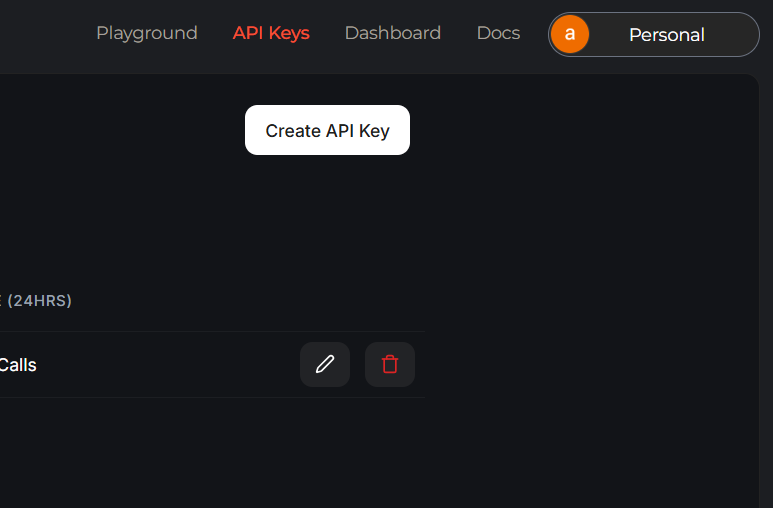

**Insert here your api key:**

In [ ]:
api_key = getpass.getpass("🔑 Enter your Groq API key: ")

**Load config yaml file**

In [ ]:
# Load the configuration file "config.yaml" on the repo
config = load_config("archaicIT2modernIT/config.yaml")

# Load of all the parameters (model names and temperature)
deepseek = config["model"]["deepseek"]
gemma = config["model"]["gemma"]
llama = config["model"]["llama"]
model_temperature = config["model"]["temperature"]

# Load italian system and user prompts (as tuples (system_prompt, user_prompt))
prompt_it = (config['prompt']['system_template_it'], config['prompt']['user_template_it'])

# Load english system and user prompts
prompt_en = (config['prompt']['system_template_en'],config['prompt']['user_template_en'])

# Load the requests per minute param
req_per_min = config["rate_limit"]["req_per_min"]

print(f"Model names: {deepseek}, {gemma}, {llama}\n")
print(f"System Prompt IT:\n{prompt_it[0]}")
print(f"User Prompt IT:\n{prompt_it[1]}")
print(f"System Prompt EN:\n{prompt_en[0]}")
print(f"User Prompt EN:\n{prompt_en[1]}")
print(f"Model temperature: {model_temperature}\n")
print(f"Requests per minute: {req_per_min}\n")

**Load Examples**

These examples are the ones used for the **few-shot learning** from 1-shot to the 5-shot.

In [ ]:
examples_csv = pd.read_csv("archaicIT2modernIT/data/examples.csv")
examples = [(archaic, modern) for archaic, modern in zip(examples_csv["Sentence"], examples_csv["Manual Translation"])]
examples_csv.head()

## Zero-shot translations

**Zero-Shot Prompt Builder**

In [ ]:
# Create a Zero Shot Prompt Builder for both italian and english prompt

prompt_builder_it_zeroshot = PromptBuilder(prompt_template = prompt_it,
                                  mode = "zero-shot",
                                  lang = 'it'
                                  )

prompt_builder_en_zeroshot = PromptBuilder(prompt_template = prompt_en,
                                  mode = "zero-shot",
                                  lang = 'en'
                                  )

**LLMs translation**

In this section we use the prompt builder to translate the dataset in the case of "zero-shot" with all the LLMs.

In [ ]:
# Create a list of models with the temperatures
list_of_models = [deepseek ]#gemma, deepseek]
list_of_temperatures = [model_temperature for _ in range(len(list_of_models))]

for model, temperature in zip(list_of_models, list_of_temperatures):

    print(f"Model: {model}, Temperature: {temperature}")

    LLM_translation(
        api_key = api_key,
        input_file = "archaicIT2modernIT/data/dataset.csv",
        model_name = model,
        prompt_builder = prompt_builder_it_zeroshot,
        temperature = temperature,
        req_per_min = req_per_min,
        save_path = "archaicIT2modernIT/translations"
)

for model, temperature in zip(list_of_models, list_of_temperatures):

    print(f"Model: {model}, Temperature: {temperature}")

    LLM_translation(
        api_key = api_key,
        input_file = "archaicIT2modernIT/data/dataset.csv",
        model_name = model,
        prompt_builder = prompt_builder_en_zeroshot,
        temperature = temperature,
        req_per_min = req_per_min,
        save_path = "archaicIT2modernIT/translations"
)

## Few-shot translations

**Choose K through slider**

K is the number of sentence-translation pairs to give for the in-context learning

In [ ]:
k_slider = widgets.IntSlider(
    value=1,           # default value
    min=1,
    max=5,
    step=1,
    description='K:',
    continuous_update=False
)
display(k_slider)


**Few-Shot Prompt Builder**

In [ ]:
print(f"You are using K={k_slider.value} examples in few-shot learning")

prompt_builder_it_fewshot = PromptBuilder(prompt_template = prompt_it,
                                  mode = "few-shot",
                                  k = k_slider.value,
                                  examples = examples,
                                  lang = 'it'
                                  )
prompt_builder_en_fewshot = PromptBuilder(prompt_template = prompt_en,
                                  mode = "few-shot",
                                  k = k_slider.value,
                                  examples = examples,
                                  lang = 'en'
                                  )

**LLMs translation**

In this section we use the prompt builder to translate the dataset in the case of "k-shot" with all the LLMs.

In [ ]:
# Create a list of models with the temperatures
list_of_models = [gemma, deepseek]
list_of_temperatures = [model_temperature for _ in range(len(list_of_models))]

for model, temperature in zip(list_of_models, list_of_temperatures):

    print(f"Model: {model}, Temperature: {temperature}")

    LLM_translation(
        api_key = api_key,
        input_file = "archaicIT2modernIT/data/dataset.csv",
        model_name = model,
        prompt_builder = prompt_builder_it_fewshot,
        temperature = temperature,
        req_per_min = req_per_min,
        save_path = "archaicIT2modernIT/translations"
)

for model, temperature in zip(list_of_models, list_of_temperatures):

    print(f"Model: {model}, Temperature: {temperature}")

    LLM_translation(
        api_key = api_key,
        input_file = "archaicIT2modernIT/data/dataset.csv",
        model_name = model,
        prompt_builder = prompt_builder_en_fewshot,
        temperature = temperature,
        req_per_min = req_per_min,
        save_path = "archaicIT2modernIT/translations"
)

# Transformer-based Approach

## Initializations

**Load the dataset from Huggingface**

This dataset is needed for fine tuning purpose of the transformer based approach.

In [ ]:
# Download and load CSV using pandas
url = "https://huggingface.co/datasets/cybernetic-m/oldIT2modIT/resolve/main/oldIT2modIT_dataset.csv"
old2modern_df = pd.read_csv(url)
# Rename the columns
old2modern_df = old2modern_df.rename(columns={'Old': 'src', 'Modern': 'tgt'})
# Convert to Hugging Face Dataset
old2modern_dataset = Dataset.from_pandas(old2modern_df)

**Definition of the Non Fine-Tuned Transformer**

In [ ]:
model = "facebook/nllb-200-distilled-600M"
model_name = "nllb-200-distilled-600M"
save_path = "/content/archaicIT2modernIT/translations"
input_file = "/content/archaicIT2modernIT/data/dataset.csv"

nonfinetuned_tokenizer = AutoTokenizer.from_pretrained(model)
nonfinetuned_model = AutoModelForSeq2SeqLM.from_pretrained(model)

## Translation using Non Fine Tuned model

In [ ]:
Transformer_translation(input_file = input_file,
                        model = nonfinetuned_model,
                        model_name = model_name,
                        tokenizer = nonfinetuned_tokenizer,
                        save_path = save_path
                        )

**Tokenize dataset**

In [ ]:
# Tokenizing the dataset
tokenized_dataset = old2modern_dataset.map(preprocess,fn_kwargs={"tokenizer": nonfinetuned_tokenizer})

## Fine-Tuning of the Transformer

In [ ]:
# Training arguments
train_args = TrainingArguments(
    output_dir = './finetune-result',   # where to save the model checkpoints and logs
    per_device_train_batch_size=5,  # batch_size per GPU
    num_train_epochs=3,             # number of full passes on the entire dataset
    logging_steps=10,               # print logs every 10 steps (1 step is 1 batch passing in training)
    save_steps=500,                   # save model weights every 10 steps (if you define batch_size such that steps < save_steps -> Save no checkpoint, only at the end)
    eval_strategy="no",             # if a validation set is available
    save_total_limit=1,             # limit number of checkpoint to save in output_dir (the oldest one will be deleted)
    fp16=True                       # use mixed precision training
)

# Initialize the trainer object
trainer = Trainer(
    model=nonfinetuned_model,
    args=train_args,
    train_dataset=tokenized_dataset
)

# To save also the tokenizer
nonfinetuned_tokenizer.save_pretrained(train_args.output_dir)

In [ ]:
# Training Loop
trainer.train()

## Translations with fine tuning

**Load the model and the tokenizer**

In [ ]:
# Load tokenizer from base model
model_name="nllb-200-distilled-600M-finetuned"
finetuned_tokenizer = AutoTokenizer.from_pretrained('/content/finetune-result')
finetuned_model = AutoModelForSeq2SeqLM.from_pretrained('/content/finetune-result/checkpoint-120')

In [ ]:
Transformer_translation(input_file = input_file,
                        model = finetuned_model,
                        model_name = model_name,
                        tokenizer = finetuned_tokenizer,
                        save_path = save_path
                        )

# LLM as a Judge

## Initializations

In [ ]:
prometheus_model = AutoModelForCausalLM.from_pretrained("prometheus-eval/prometheus-7b-v2.0")
prometheus_tokenizer = AutoTokenizer.from_pretrained("prometheus-eval/prometheus-7b-v2.0")

In [ ]:
# Load the configuration file "config.yaml" on the repo
config = load_config("archaicIT2modernIT/config.yaml")

# Load of all the parameters
rel_system_prompt = config["prometheus_judge"]["relative"]['system_prompt']
rel_user_prompt = config["prometheus_judge"]["relative"]['user_prompt']

abs_system_prompt = config["prometheus_judge"]["absolute"]['system_prompt']
abs_user_prompt = config["prometheus_judge"]["absolute"]['user_prompt']

gold_path = '/content/archaicIT2modernIT/data/dataset_gold.csv'

print(f"Relative system prompt: {rel_system_prompt}\n")
print(f"Relative user prompt: {rel_user_prompt}\n")

print(f"Absolute system prompt: {abs_system_prompt}\n")
print(f"Absolute user prompt: {abs_user_prompt}\n")

## Tournament selection

In the tournament we want to find the best gemma and deepseek lama model using prometheus. We will do this by asking to prometheus which translation is better between translation A or translation B.

In [ ]:
gemma_files = ['/content/archaicIT2modernIT/translations/zeroShot_temp0_it/CaponataLovers-hw2_transl-gemma2-9b-it_zero-shot_it_temp-0.0.jsonl',
               '/content/archaicIT2modernIT/translations/fewShot1_temp0_it/CaponataLovers-hw2_transl-gemma2-9b-it_few-shot_k-1_it_temp-0.0.jsonl',
               '/content/archaicIT2modernIT/translations/fewShot2_temp0_it/CaponataLovers-hw2_transl-gemma2-9b-it_few-shot_k-2_it_temp-0.0.jsonl',
               '/content/archaicIT2modernIT/translations/fewShot3_temp0_it/CaponataLovers-hw2_transl-gemma2-9b-it_few-shot_k-3_it_temp-0.0.jsonl']

deepseek_files = ['/content/archaicIT2modernIT/translations/zeroShot_temp0_it/CaponataLovers-hw2_transl-deepseek-r1-distill-llama-70b_zero-shot_it_temp-0.0.jsonl',
               '/content/archaicIT2modernIT/translations/fewShot1_temp0_it/CaponataLovers-hw2_transl-deepseek-r1-distill-llama-70b_few-shot_k-1_it_temp-0.0.jsonl',
               '/content/archaicIT2modernIT/translations/fewShot2_temp0_it/CaponataLovers-hw2_transl-deepseek-r1-distill-llama-70b_few-shot_k-2_it_temp-0.0.jsonl',
               '/content/archaicIT2modernIT/translations/fewShot3_temp0_it/CaponataLovers-hw2_transl-deepseek-r1-distill-llama-70b_few-shot_k-3_it_temp-0.0.jsonl']

prompt_judge_tournament = (rel_system_prompt, rel_user_prompt)

prompt_builder = PromptBuilder(prompt_template = prompt_judge_tournament,
                               mode = "zero-shot",
                               lang = 'en'
                              )
# Gemma Tournament
tournament(files = gemma_files,
           judge_model=prometheus_model,
           judge_tokenizer=prometheus_tokenizer,
           prompt_builder=prompt_builder,
           gold_path = gold_path
           )

# Deepseek Tournament
tournament(files = deepseek_files,
           judge_model=prometheus_model,
           judge_tokenizer=prometheus_tokenizer,
           prompt_builder=prompt_builder,
           gold_path = gold_path
           )

## Absolute evaluation

After the tournament we will perform the absolute evaluation with rubric score on 5 different metrics for each model: the deepseek winner, the gemma winner and the transformer FT and non-FT

In [ ]:
prompt_judge_abs = (abs_system_prompt, abs_user_prompt)

prompt_builder_abs = PromptBuilder(prompt_template = prompt_judge_abs,
                                  mode = "zero-shot",
                                  lang = 'en'
                                  )
rubrics =  {'meaning_preservation': config["prometheus_judge"]["absolute"]["rubrics"]['meaning_preservation'],
            'grammar': config["prometheus_judge"]["absolute"]["rubrics"]['grammar'],
            'modern_structural_effectiveness': config["prometheus_judge"]["absolute"]["rubrics"]['modern_structural_effectiveness'],
            'completeness': config["prometheus_judge"]["absolute"]["rubrics"]['completeness'],
            'lexical_modernization': config["prometheus_judge"]["absolute"]["rubrics"]['lexical_modernization']}

to_eval_list = [
    '/content/archaicIT2modernIT/translations/fewShot1_temp0_it/CaponataLovers-hw2_transl-deepseek-r1-distill-llama-70b_few-shot_k-1_it_temp-0.0.jsonl',
    '/content/archaicIT2modernIT/translations/fewShot3_temp0_it/CaponataLovers-hw2_transl-gemma2-9b-it_few-shot_k-3_it_temp-0.0.jsonl',
    '/content/archaicIT2modernIT/translations/transformers/CaponataLovers-hw2_transl-nllb-200-distilled-600M.jsonl',
    '/content/archaicIT2modernIT/translations/transformers/CaponataLovers-hw2_transl-nllb-200-distilled-600M-finetuned.jsonl'
]

output_file_path_list = [
    '/content/archaicIT2modernIT/evaluations/deepseek_evaluation.jsonl',
    '/content/archaicIT2modernIT/evaluations/gemma_evaluation.jsonl',
    '/content/archaicIT2modernIT/evaluations/transformer_non_ft_evaluation.jsonl',
    '/content/archaicIT2modernIT/evaluations/transformer_ft_evaluation.jsonl'
]
for model_path, output_file_path in zip(to_eval_list, output_file_path_list):
  print(f"Model: {model_path}")
  #this funciton will evaluate all the models saved in the file winners.txt,
  make_evaluation(
      to_eval= model_path,
      output_file_path = output_file_path,
      judge_model = prometheus_model,
      judge_tokenizer = prometheus_tokenizer,
      prompt_builder = prompt_builder_abs,
      rubrics = rubrics,
      gold_path = gold_path
      )

**Cohen's Kappa Coefficient**

Useful to see the correlation between our votes and the prometheus votes

In [ ]:
path_list = [
    '/content/archaicIT2modernIT/human_correlation/deepseek_eval_correlation.jsonl',
    '/content/archaicIT2modernIT/human_correlation/gemma_eval_correlation.jsonl',
    '/content/archaicIT2modernIT/human_correlation/transformer_ft_eval_correlation.jsonl',
    '/content/archaicIT2modernIT/human_correlation/transformer_non_ft_eval_correlation.jsonl'
]

cohen_kappa_dict = {}
eval_dict = {}

PrepareData4CohenKappa(path_list = path_list, eval_dict = eval_dict)
CohenKappaComputation(eval_dict = eval_dict, cohen_kappa_dict = cohen_kappa_dict)